In [1]:
# %%  imports 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import time
from scipy.stats import genextreme, genpareto
from datetime import datetime

In [2]:
def get_list_simulations(root_dir):
    """
    Get a list with all the name of the simulation csv files.
    """
    file_list_simulations = []
    for _, file in enumerate(os.listdir(root_dir)):
        file_list_simulations.append(file)
    return file_list_simulations

def get_dict_scenario_txt(file_list_simulations):
    """
    Build dictionary of scenario number and the corresponding name of the csv file
    with simulation data.
    """
    simulation_files_dict = {}
    for file_name in file_list_simulations:
        if file_name.endswith('.docx'):
            continue
        else:
            #simulation_files_dict[str(file_name.split("_")[1]) + '_' + str(file_name.split("_")[3].rstrip('.txt'))] = file_name
            simulation_files_dict[str(file_name.split("_")[1])] = file_name
    return simulation_files_dict

def convert_objects_to_float(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert columns with object dtype to floats in order to use them in models.
    """
    indicator = df.dtypes == 'object'
    categorical_columns = df.columns[indicator].tolist()
    for col in categorical_columns:
        try:
            df[col] = df[col].astype('float')
        except:
            continue
    return df

def read_txt_to_df(file, root_dir):
    """
    read individual channel txt file to a df
    """
    file_path = os.path.join(root_dir, file)
    #df = pd.read_csv(file_path, sep='\t', header=[0,1])
    df = pd.read_csv(file_path, sep='\t')
    columns = ["date", "Q-factor", "Power", "CD", "PMD"] 
    df.columns = columns
    df = convert_objects_to_float(df)
    return df

def down_sample(df, sam):
    """
    downsample by a factor 'sam' and return Q and CD arrays 
    """
    sam = int(sam)
    Qarr = df["Q-factor"].to_numpy()
    CDarr = df["CD"].to_numpy()
    PMDarr = df["PMD"].to_numpy()
    Qarr = np.asarray([Qarr[i] for i in range(0, round(len(Qarr)), sam)])
    CDarr = np.asarray([CDarr[i] for i in range(0, round(len(CDarr)), sam)])
    PMDarr = np.asarray([PMDarr[i] for i in range(0, round(len(PMDarr)), sam)])
    return Qarr, CDarr, PMDarr

def convert_Q_to_array(df):
    """
    downsample by a factor 'sam' and return Q and CD arrays 
    """
    Qarr = df["Q-factor"].to_numpy()
    return Qarr

def get_segment(channel):
    """
    get segment from channel number 
    """
    channel = str(channel)
    return int(simulation_files_dict[channel].split("_")[3].rstrip('.txt'))

def get_discontinuities_in_time(time_column):
    """
    get the indices for which the next 
                        """
    discons = []
    for i in range(len(time_column) - 1):
        if time_column[i+1] - time_column[i] > 15.0 or time_column[i+1] - time_column[i] < 0:
            discons.append(i+1)
    return discons

def get_contiguous_bactches(discons, Q):
    """
    split up Q into contiguous segments 
    """  
    discons = [0] + discons
    segs = []
    for i in range(len(discons) -1 ):
        segs.append(Q[discons[i]:discons[i+1]])
    return segs


def check_for_fully_contiguous_channels(channel):
    """
    read in data for one channel, get the time column, convert Q to an array and 
    split data into contiguous batches 
    """
    df = read_txt_to_df(simulation_files_dict[channel], root_dir)
    timecol = get_times_from_dates(df)
    #print(df['Q-factor'][0])   
    return  check_for_discon_in_time(timecol)

def check_for_discon_in_time(time_column):
    """
    get the indices for which the next 
                        """
    
    for i in range(len(time_column) - 1):
        if time_column[i+1] - time_column[i] > 15.0:
            discon = True
        else:
            discon = False
    return discon

def autocorr(x):
    x = x - np.mean(x)
    auto_corr = np.correlate(x, x, mode='full')
    index_max = np.argmax(auto_corr)
    return auto_corr[index_max:]/auto_corr[index_max]

def count_outliers(snrarr, up, low):
    outliers = 0
    inds = []
    for k in range(len(snrarr)):
        if snrarr[k] > max(up) or snrarr[k] < min(low):  # count outliers above and below 
        #if snrarr[k] < min(low):  # count outliers below = could cause outage
            outliers = outliers + 1
            inds.append(k)
    return outliers, inds

def count_outliers_evs(snrarr, low):
    outliers = 0
    for k in range(len(snrarr)):
        #if snrarr[k] > max(up) or snrarr[k] < min(low):  # count outliers above and below 
        if snrarr[k] < min(low):  # count outliers below = could cause outage
            outliers = outliers + 1
    return outliers

def get_times_from_dates(df):
    """
    convert dates column to timestamps 
    """
    time_stamps = []
    dates = df['date']
    date_time_0 = datetime.strptime(dates[0], '%Y.%m.%d.%H.%M.%S')
    time_stamp_0 = datetime.timestamp(date_time_0)
    for i in range(len(dates)-1):
        date_time = datetime.strptime(dates[i+1], '%Y.%m.%d.%H.%M.%S')
        time_stamp = datetime.timestamp(date_time)
        time_stamps.append((time_stamp - time_stamp_0)/60)
    time_stamps = [0.0] + time_stamps
    return time_stamps

def db2lin(x):
    return 10**(x/10)

def calc_capacity(prmnn):
    return 32*np.log2(1+db2lin(min(prmnn)))

def find_Q_drops(channels, Q_thresh):
    """
    parse through a given list of channels and locate the batch and index of 
    the Q-drop events, defined as where Q changes by more than Q_thresh
    """
    q_drops = []
    for i in channels:
        timecol, discons, batches, _ =  read_data_and_return_largest_batch(i)
        for j in range(len(batches)):
            batch_ind = j
            Qbat = batches[batch_ind]
            Qbat_time = timecol[discons[batch_ind]:discons[batch_ind+1]]/(60)
            q_drop_inds = get_Q_drops_and_spikes(Qbat, Q_thresh)
            if len(q_drop_inds) == 0:
                continue
            else:
                q_drops.append([i, batch_ind, q_drop_inds])
    return q_drops
def get_Q_drops_and_spikes(Qbat, Q_thresh):
    """
    get the indices corresponding to Q-drop events for a given batch of data
                        """
    drop_inds = []
    for i in range(len(Qbat) - 1):
        if Qbat[i+1] - Qbat[i] > Q_thresh or Qbat[i+1] - Qbat[i] < -Q_thresh:
            drop_inds.append(i+1)
    return drop_inds

def read_data_and_return_largest_batch(channel):

    #print("segment = " + str(get_segment(channel)))
    df = read_txt_to_df(simulation_files_dict[channel], root_dir)
    timecol = get_times_from_dates(df)
    df = df.drop('date', axis =1)
    df['time'] = timecol
    #df = drop_bad_values(df)
    timecol = df['time'].to_numpy()
    discons = get_discontinuities_in_time(timecol)
    #Qarr, _, _, _ = down_sample(df, 1) # set sam = 1 to just return arrays with same sampling
    Qarr = convert_Q_to_array(df)
    batches = get_contiguous_bactches(discons, Qarr)
    # batchescd = get_contiguous_bactches(discons, CDarr)
    # batchespmd = get_contiguous_bactches(discons, PMDarr)
    # batchespch = get_contiguous_bactches(discons, Pcharr)
    batch_lens = ([len(i) for i in batches ])
    batch_max = batch_lens.index(max(batch_lens))
    discons = [0] + discons
    return timecol, discons, batches, batch_max

def snr_to_ber_QPSK(x):
    """
    convert from linear SNR to BER for QPSK signal
    """
    return 0.5*erfc((x/2)**0.5)
def ber_to_snr_QPSK(x):
    """
    convert from BER to linear SNR for QPSK signal
    """
    return ((erfcinv(2*x))**2)*2

def lin2db(x):
    """
    convert from linear to dB
    """
    return 10*np.log10(x)

def get_Q_drop_dataset(Q_drops, batch_size):
    drops_data = []
    for i in range(len(Q_drops)):
        df = read_txt_to_df(simulation_files_dict[Q_drops[i][0]], root_dir)
        timecol = get_times_from_dates(df)
        df = df.drop('date', axis =1)
        df['time'] = timecol
        timecol = df['time'].to_numpy()
        discons = get_discontinuities_in_time(timecol)
        Qarr = convert_Q_to_array(df)
        batches = get_contiguous_bactches(discons, Qarr)
        discons = [0] + discons
        batch_ind = Q_drops[i][1]
        Qarr = batches[batch_ind]
        slice_low = Q_drops[i][2][0] 
        slice_high = Q_drops[i][2][0] + batch_size
        snr = Qarr[slice_low:slice_high]
        snr = snr.reshape(len(snr),1)
        drops_data.append(snr)
    return drops_data
def get_Q_steady_dataset(q_steady, batch_size):
    steady_data = []
    for i in range(len(q_steady)):
        df = read_txt_to_df(simulation_files_dict[q_steady[i][0]], root_dir)
        timecol = get_times_from_dates(df)
        df = df.drop('date', axis =1)
        df['time'] = timecol
        timecol = df['time'].to_numpy()
        discons = get_discontinuities_in_time(timecol)
        Qarr = convert_Q_to_array(df)
        batches = get_contiguous_bactches(discons, Qarr)
        discons = [0] + discons
        batch_ind = q_steady[i][1]
        Qarr = batches[batch_ind]
        slice_low = 0
        slice_high = batch_size
        snr = Qarr[slice_low:slice_high]
        snr = snr.reshape(len(snr),1)
        steady_data.append(snr)
    return steady_data

def find_steady_state_channels(channels, Q_thresh):
    """
    parse through a given list of channels and locate the batch and index of 
    the Q-drop events, defined as where Q changes by more than Q_thresh
    """
    q_steady = []
    for i in channels:
        timecol, discons, batches, _ =  read_data_and_return_largest_batch(i)
        parsing = True
        while parsing:
            j = 0
            batch_ind = j
            Qbat = batches[batch_ind]
            Qbat_time = timecol[discons[batch_ind]:discons[batch_ind+1]]/(60)
            q_drop_inds = get_Q_drops_and_spikes(Qbat, Q_thresh)
            if len(q_drop_inds) == 0:
                q_steady.append([i, batch_ind])
                parsing = False
            else:
                j = j + 1
    return q_steady

def find_steady_state_batches(channel, Q_thresh):
    """
    parse through a given channel and find the steady-state batches
    """
    q_steady = []
    timecol, discons, batches, _ =  read_data_and_return_largest_batch(channel)
    for i in range(len(batches)):
        batch_ind = i
        Qbat = batches[batch_ind]
        Qbat_time = timecol[discons[batch_ind]:discons[batch_ind+1]]/(60)
        q_drop_inds = get_Q_drops_and_spikes(Qbat, Q_thresh)
        if len(q_drop_inds) == 0:
            q_steady.append(Qbat)
        else:
            continue
    return q_steady

def get_Q_drop_dataset(Q_drops, batch_size):
    drops_data = []
    for i in range(len(Q_drops)):
        df = read_txt_to_df(simulation_files_dict[Q_drops[i][0]], root_dir)
        timecol = get_times_from_dates(df)
        df = df.drop('date', axis =1)
        df['time'] = timecol
        timecol = df['time'].to_numpy()
        discons = get_discontinuities_in_time(timecol)
        Qarr = convert_Q_to_array(df)
        batches = get_contiguous_bactches(discons, Qarr)
        discons = [0] + discons
        batch_ind = Q_drops[i][1]
        Qarr = batches[batch_ind]
        slice_low = Q_drops[i][2][0]
        #slice_high = Q_drops[i][2][1] 
        slice_high = Q_drops[i][2][0] + batch_size
        snr = Qarr[slice_low:slice_high]
        snr = snr.reshape(len(snr),1)
        drops_data.append(snr)
    return drops_data

def return_period_vs_batch_size(ext_val, snr, batch_sizes):
    """
    calculate the variation of the return period with sample batch size 
    """
    ret_pers = []
    shapes = []
    locs = []
    scales = []
    num_bats_tot = []
    for i in batch_sizes:
        num_bats = int(np.floor(len(snr)/i))
        ind_max = int(i*num_bats)
        snr_min = (np.reshape(snr[:ind_max], (num_bats,-1)))
        snr_min = np.array([min(snr_min[k]) for k in range(num_bats)])
        shape, loc, scale = genextreme.fit(snr_min)
        ext_prob = genextreme.cdf(ext_val, shape, loc, scale)
        ret_pers.append((i/(4*24))/ext_prob)  # return period in days
        shapes.append(shape)
        locs.append(loc)
        scales.append(scale)
        num_bats_tot.append(num_bats)
    return ret_pers, shapes, locs, scales, num_bats_tot
def fit_GEV(snr, bat_max_size):
    num_bats = int(np.floor(len(snr)/bat_max_size))
    ind_max = int(bat_max_size*num_bats)
    snr_min = (np.reshape(snr[:ind_max], (num_bats,-1)))
    snr_min = np.array([min(snr_min[i]) for i in range(num_bats)])
    shape, loc, scale = genextreme.fit(snr_min)
    return shape, loc, scale 
def get_num_values(snr, snr_th):
    return len([i for i in snr if i <= snr_th])

def return_period(ext_val, shape, loc, scale, batch_size):
    """
    calculate the variation of the return period with sample batch size 
    """
    ext_prob = genextreme.cdf(ext_val, shape, loc, scale)
    ret_per = ((batch_size/(4*24))/ext_prob)  # return period in days
    return ret_per

In [3]:
# get files and make a dictionary 
root_dir = '/Users/joshnevin/Desktop/MicrosoftDataset'
file_list_simulations= get_list_simulations(root_dir)
simulation_files_dict = get_dict_scenario_txt(file_list_simulations)

Read in a channel 

batch size 3800


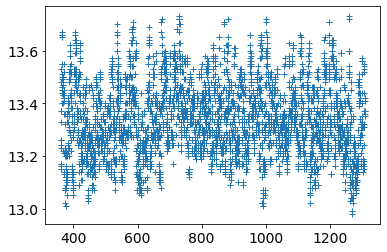

[0.75]


In [4]:
#channel = '1375'
#channel = '538'
#channel = '539'
channel = '1597'
#channel = '341'
df = read_txt_to_df(simulation_files_dict[channel], root_dir)
timecol = get_times_from_dates(df)
df = df.drop('date', axis =1)
df['time'] = timecol
timecol = df['time'].to_numpy()
discons = get_discontinuities_in_time(timecol)
#Qarr, _, _ = down_sample(df, 1) # set sam = 1 to just return arrays with same sampling
Qarr = convert_Q_to_array(df)
#snr = Qarr[15870:]  # for comparison with Seb's implementation 
batches = get_contiguous_bactches(discons, Qarr)
discons = [0] + discons
batchlens = ([len(i) for i in batches ] )
batch_max = batchlens.index(max(batchlens))
batch_ind = batch_max # note: first index is now 0 in batches list 
#batch_ind = 4 # try 16 too
Qarr = batches[batch_ind]
print("batch size " + str(len(Qarr)))
# slice_low = 300 # slice values for channel 345 example 
# slice_high = 400
slice_low = 0
slice_high = -1
snr = Qarr
#snr = Qarr[slice_low:slice_high]
snr = snr.reshape(len(snr),1)
timecol = timecol[discons[batch_ind]:discons[batch_ind+1]]
xscale = 1
# xplt = timecol[slice_low:slice_high]/(60*xscale)
# x = timecol[slice_low:slice_high]/(60*xscale) - timecol[slice_low]/(60*xscale)
xplt = timecol/(60*xscale)
x = timecol/(60*xscale) - timecol[0]/(60*xscale)
x = x.reshape(len(x), 1)
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(facecolor='w')
plt.plot(xplt, snr, '+')
#plt.savefig('figures/EVS_ch112.pdf', dpi=200,bbox_inches='tight')
plt.show()
print(max(snr) - min(snr))

Save SNR csv file for TimeGAN input 

In [5]:
np.savetxt('/Users/joshnevin/TimeGAN/data/channel_1597_SNR.csv', snr, delimiter=',') 

plot histogram of SNR values $\leq$ some threshold 

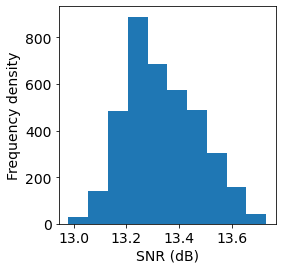

In [6]:
snr_sorted = np.sort(snr.reshape(len(snr),))
snr_sorted = [i for i in snr_sorted if i <= 13.95]
fig, ax = plt.subplots(facecolor='w')
plt.hist(snr_sorted)
#plt.hist(snr)
plt.ylabel("Frequency density")
plt.xlabel("SNR (dB)")
#plt.xlim([13.85, 13.95])
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/hist_snr.pdf', dpi=200,bbox_inches='tight')
plt.show()

obtain minima from regular batches of SNR data 

In [7]:
bat_max_size = 5
num_bats = int(np.floor(len(snr)/bat_max_size))
#num_bats = int(np.floor(len(snr_subset_train)/bat_max_size))
ind_max = int(bat_max_size*num_bats)
snr_min = (np.reshape(snr[:ind_max], (num_bats,-1)))
#snr_min = (np.reshape(snr_subset_train[:ind_max], (num_bats,-1)))
snr_min = np.array([min(snr_min[i]) for i in range(num_bats)])
#snr_min = db2lin(snr_min)
# plt.hist(snr_min)
# #plt.savefig("figures/SNR_min_hist.pdf", dpi = 200, bbox_inches='tight')
# plt.show()

fit EVS distribution using marginal likelihood 

shape, loc, scale = 0.14775154299573307, 13.221110414050269, 0.11286229748342655


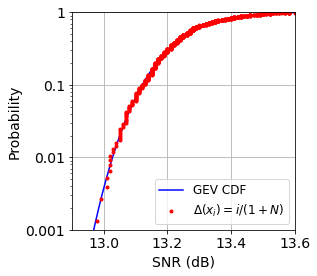

In [8]:
shape, loc, scale = genextreme.fit(snr_min)
print("shape, loc, scale = " + str(shape) + ', ' + str(loc) + ', ' + str(scale))
gev_cdf_x = np.linspace(5,15,100000)
snr_y = (np.linspace(1,num_bats,num_bats))/(1+len(snr_min))  # empirical probability
#fig, ax = plt.subplots(facecolor='w')
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111)
plt.semilogy(gev_cdf_x, genextreme.cdf(gev_cdf_x, shape, loc, scale), 'b-', label = "GEV CDF")
plt.semilogy(np.sort(snr_min), snr_y, 'r.', label = "$\Delta(x_i) = i/(1+N)$")
plt.xlim([12.9,13.6])
plt.ylim([1e-3,1])
# ax1.set_yticklabels([0.01, 0.1, 1])
# ax1.set_yticks([0.01, 0.1, 1])
plt.ylabel("Probability")
plt.yticks([0.001, 0.01, 0.1, 1])
ax1.set_yticklabels([0.001, 0.01, 0.1, 1])
#plt.xlabel("SNR (dB)")
plt.xlabel("SNR (dB)")
plt.legend(loc=4, prop={'size': 12})
plt.grid()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/OFC_fig_1.pdf', dpi=200,bbox_inches='tight')
plt.show()

Find the EVS-generated probability of the extreme events and their return period. Can use this to estimate the return period that equates to one year for a given precision.

In [9]:
ext_prob = genextreme.cdf(12.94, shape, loc, scale)
print("P(Mn <= x) = %.6f" % ext_prob)
ret_per = (bat_max_size/(4*24))/ext_prob  # return period in days
print("Return period = %.1f days" % ret_per)

P(Mn <= x) = 0.000239
Return period = 217.7 days


Generate "train" and "test" subsets for empirical value comparison. Compare the distributions of the two subsets visually. 

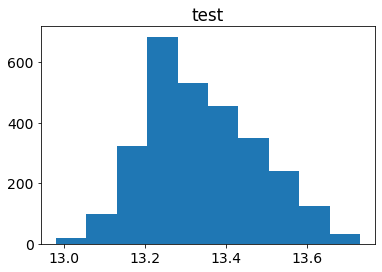

13.33882807017544
0.13620635242210777


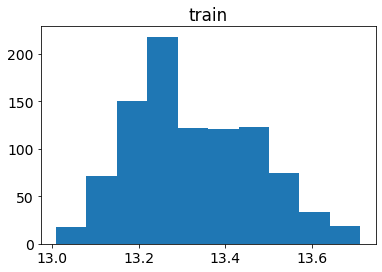

13.324526315789473
0.14190855781510656


In [10]:
snr_subset_train = snr[:int(np.floor(len(snr)/4))]
snr_subset_test = snr[int(np.floor(len(snr)/4)):]
plt.hist(snr_subset_test)
plt.title("test")
plt.show()
print(np.mean(snr_subset_test))
print(np.std(snr_subset_test))
plt.hist(snr_subset_train)
plt.title("train")
plt.show()
print(np.mean(snr_subset_train))
print(np.std(snr_subset_train))

Fit GEV distributions to the training data subset for low, medium and high values of the sample size for minima, $n$.  
Use $n=3,5,10$ for paper.  

This code was used to produce Figures 3 and 4.

In [11]:
bat_size_high = 10
bat_size_med = 5
bat_size_low = 3

shape_subset_h, loc_subset_h, scale_subset_h = fit_GEV(snr_subset_train, bat_size_high)
shape_subset, loc_subset, scale_subset = fit_GEV(snr_subset_train, bat_size_med)
shape_subset_l, loc_subset_l, scale_subset_l = fit_GEV(snr_subset_train, bat_size_low)

test_snrs = [12.98, 12.99, 13, 13.01, 13.02, 13.03, 13.04, 13.05, 13.06] # 1597
test_snrs_cont = np.linspace(min(snr_subset_train)-0.05, min(snr_subset_train)+0.05, 10)

return_periods_h = []
return_periods_l = []
return_periods = []
for i in test_snrs_cont:
    return_period_h = return_period(i, shape_subset_h, loc_subset_h, scale_subset_h, bat_size_high)
    return_periods_h.append(return_period_h)
    return_period_l = return_period(i, shape_subset_l, loc_subset_l, scale_subset_l, bat_size_low)
    return_periods_l.append(return_period_l)
    return_period_o = return_period(i, shape_subset, loc_subset, scale_subset, bat_size_med)
    return_periods.append(return_period_o)

total_time = len(snr_subset_test)*0.25/24
emp_ret_per_sim = []
for i in test_snrs:
    try:
        emp_ret_per_sim.append(total_time/(get_num_values(snr_subset_test, i)))
    except:
        emp_ret_per_sim.append(np.nan)

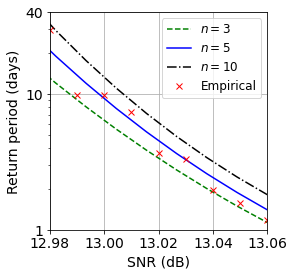

In [12]:
one_yr = 365*np.ones([len(test_snrs_cont),1])
#fig, ax = plt.subplots(facecolor='w')
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.semilogy(test_snrs_cont[:], return_periods_l[:], 'g--', label='$n=3$')
ax.semilogy(test_snrs_cont[:], return_periods[:], 'b-', label='$n=5$')
ax.semilogy(test_snrs_cont[:], return_periods_h[:], 'k-.', label='$n=10$')
ax.semilogy(test_snrs[:], emp_ret_per_sim[:], 'rx', label='Empirical')
plt.ylabel("Return period (days)")
plt.xlabel("SNR (dB)")
plt.legend(loc = 1, prop={'size': 12}, ncol=1)
plt.grid()
ax.set_xticks([12.98, 13.00, 13.02, 13.04, 13.06])
ax.set_xlim([12.98,13.06])
ax.set_yticks([1, 10, 40])
ax.set_yticklabels([1, 10, 40])
ax.set_ylim(1, 40)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/OFC_fig_3.pdf', dpi=200,bbox_inches='tight')
plt.show()

Investigate the effect of the variation of batch size on the GEV parameters.

In [12]:
bat_low = 10
bat_high = 1001
batch_sizes = [i for i in range(bat_low, bat_high, 5)]
#return_periods, shapes, locs, scales = return_period_vs_batch_size(12.65, snr_subset_train, batch_sizes)
return_periods, shapes, locs, scales, num_bats_tot = return_period_vs_batch_size(12.2, snr, batch_sizes)

<ipython-input-2-0cdeb5ef2976>:348: RuntimeWarning: overflow encountered in double_scalars
  ret_pers.append((i/(4*24))/ext_prob)  # return period in days
<ipython-input-2-0cdeb5ef2976>:348: RuntimeWarning: divide by zero encountered in double_scalars
  ret_pers.append((i/(4*24))/ext_prob)  # return period in days
/Users/joshnevin/ext_val_stats/evs_env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2434: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


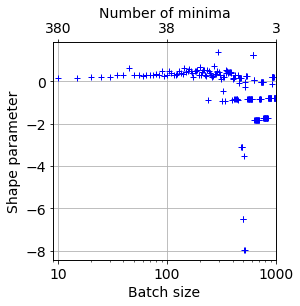

In [13]:
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.semilogx(batch_sizes, shapes, 'b+')
plt.ylabel("Shape parameter")
ax1.set_xlabel("Batch size")
ax2.set_xlabel("Number of samples")
ax1.set_xticks([10, 100, 1000])
ax1.set_xticklabels([10, 100, 1000])
ax1.set_xlim([bat_low-1,bat_high])
ax2.set_xticks([25, 510, 1000])
ax2.set_xticklabels([380, 38, 3])
ax2.set_xlabel("Number of minima")
ax1.set_ylabel("Shape parameter")
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
ax1.grid()
#plt.savefig('figures/OFC_fig_2.pdf', dpi=200,bbox_inches='tight')
plt.show()